In [1]:
# import spacy
import re
# from spacy.tokens import DocBin
from fuzzywuzzy import fuzz
import psutil
import pandas as pd
import recordlinkage as rl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyarrow
import dask.dataframe as dd
import pandas as pd
# get CPU count
import multiprocessing
try: import missingno 
except: 
    !pip install missingno
    import missingno    

# Function to report RAM usage
def report_ram_usage():
    process = psutil.Process()
    ram_usage = process.memory_info().rss / (1024 ** 2)  # in MB
    print(f"Current RAM usage: {ram_usage:.2f} MB")

# Report RAM before starting
report_ram_usage()

/users/xiet13/.local/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Current RAM usage: 302.48 MB


In [2]:
# # import local culaster from dsak
# from dask.distributed import LocalCluster

# # client = LocalCluster(n_workers = 8, threads_per_worker = 4)
# client = LocalCluster(n_workers = 2, threads_per_worker = 2)

### Read In

In [3]:
# deduped = pd.read_csv('../Output/pat_census_age_filtered_64789.csv').drop(columns = 'Unnamed: 0')
# historical reason -> deduped is actually not deduped, and needs to be deduped in this noteboook
deduped = pd.read_csv('../output/pat_census_age_filtered.csv')
# final_prepared = dd.read_parquet('../Output/final_prepared_ckpt_rl.parquet') # Used to crushed kernel
deduped

,patent_id,patent_count,recid,year,simple_weighted_score,title,labforce,occstrng,age
0,GB191124316,0,6383272,1851,0.539420,NaN,1,NaN,40.0
1,GB191123803,0,23155735,1881,0.495164,NaN,1,HOSPITAL GASMAN WIFE,45.0
2,GB191123803,0,18075430,1861,0.487056,,1,STONE QUARRIERS WIFE,25.0
3,GB191123803,1,25344368,1881,0.446069,NaN,2,DRESSMAKER,28.0
4,GB191123638,0,13280771,1881,0.636319,NaN,2,NAILOR,35.0
...,...,...,...,...,...,...,...,...,...
1422,GB189311004,0,8356416,1851,0.691250,NaN,2,AGRICULTURAL LABOURER,18.0
1423,GB188907812,0,12787895,1901,0.654545,NaN,2,FARMER,59.0
1424,GB187600824,0,11924695,1851,0.703453,NaN,2,CEMENT DEALER,40.0
1425,GB187303416,0,5846963,1851,0.654246,NaN,2,AGRICULTURAL LABOURER,24.0


In [4]:
report_ram_usage()

Current RAM usage: 304.26 MB


### Tracking Confirmation

In [5]:
# tab = prev
# del prev

In [6]:
# tab.to_parquet('../Output/task_1_connected.parquet')
# _61: double
# _51: double
# _81: double
# _91: double
# _01: double
# _11: double
# connected: int64
# -- schema metadata --
# pandas: '{"index_columns": [{"kind": "range", "name": null, "start": 0, "' + 1023

In [7]:
# !ls -lha ../output/pat_census_age_filtered.csv


In [8]:

# tab = pd.read_csv('../data_toy/task_1_connected_sample.csv')
tab = pd.read_csv('../output/task1/task_1_connected_sample.csv')


# if you produced final connected output in this toy package:
# tab = pd.read_csv('../output/task1/task_1_connected_sample.csv')
tab.connected.value_counts()

connected
2    248998
3    145640
6    111888
4     90029
5     62337
Name: count, dtype: int64

In [9]:
!ls -lha ../output/task1/task_1_connected_sample.csv

-rw-r--r-- 1 xiet13 cluster-users 31M Mar  8 13:08 ../output/task1/task_1_connected_sample.csv


In [10]:
# import pyarrow.parquet as pq
# parquet_file_path = '../Output/task_1_connected.parquet'
# schema = pq.read_schema(parquet_file_path)
# print(schema)

<Axes: >

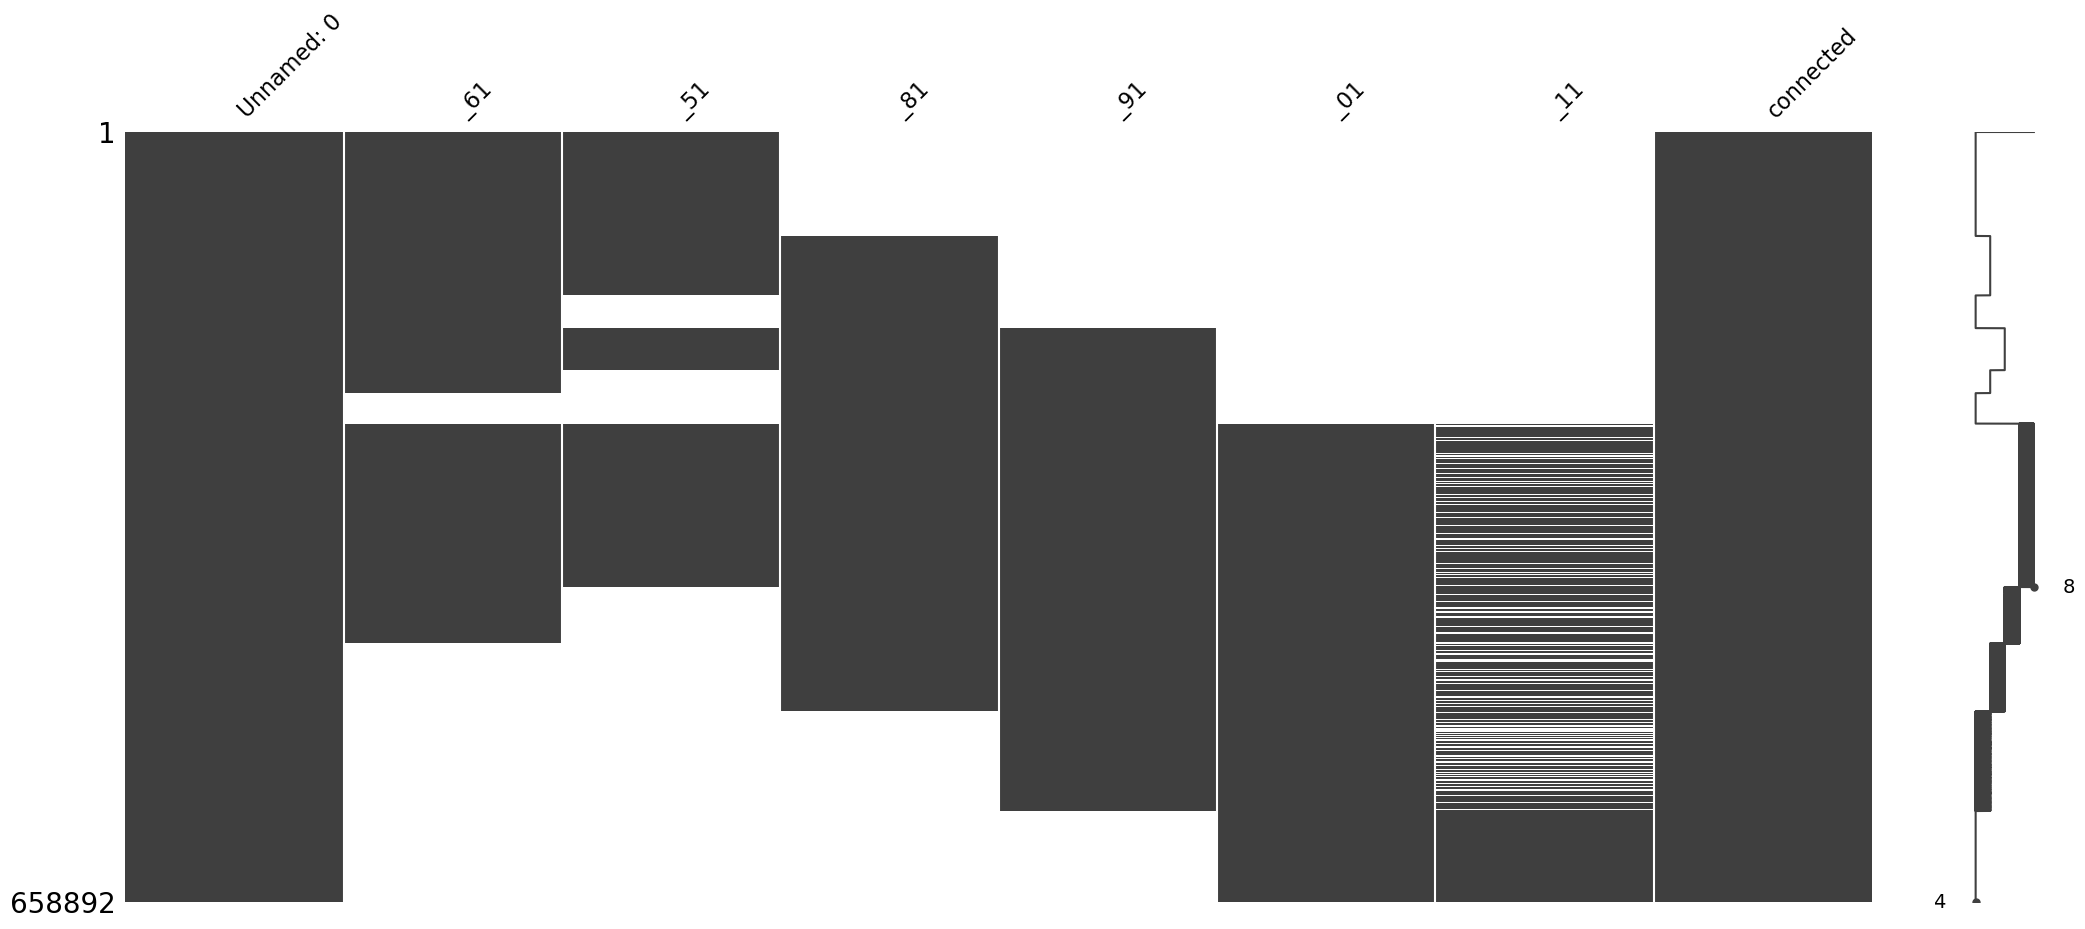

In [11]:

missingno.matrix(tab)

<Axes: >

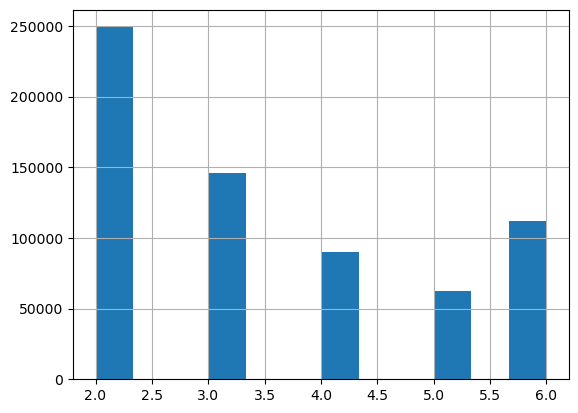

In [12]:
# tab.connected.value_counts()
# connected
# 2    15895614
# 3     6846254
# 4     3428662
# 5     1074878
# 6      507174
# Name: count, dtype: int64
tab.connected.hist(bins = 12)

In [13]:
tab[tab.connected == 6.0]

,Unnamed: 0,_61,_51,_81,_91,_01,_11,connected
0,0,15376283.0,73.0,3139800.0,10018937.0,630957.0,4388226.0,6
249578,249578,16944591.0,955.0,515062.0,13846379.0,15145036.0,10878071.0,6
249579,249579,39549.0,1080.0,6732098.0,23793627.0,26015547.0,28592263.0,6
249581,249581,17741573.0,1444.0,23518189.0,26651469.0,29275521.0,32599099.0,6
249582,249582,5048038.0,1542.0,14329871.0,1366633.0,5744643.0,6879776.0,6
...,...,...,...,...,...,...,...,...
389362,389362,19724105.0,17710511.0,26046871.0,29507402.0,32464488.0,36179159.0,6
389363,389363,19725268.0,17710520.0,26019929.0,29472668.0,32431666.0,36146236.0,6
389364,389364,19725207.0,17710878.0,26048012.0,29469066.0,32436212.0,36177622.0,6
389365,389365,19725132.0,17710910.0,26049696.0,29508715.0,32465616.0,36180136.0,6


In [14]:
# final_prepared_index_1 = final_prepared_index.get_level_values(0)
# final_prepared_index_2 = final_prepared_index.get_level_values(1).astype('int')
# final_prepared_index = pd.MultiIndex.from_arrays([final_prepared_index_1, final_prepared_index_2], names=['recid', 'year'])

In [15]:
# task3_res_idx = deduped.set_index(['patent_id',	'patent_count', 'recid', 'year']).index

In [16]:
mask_have_tracking = deduped[['patent_id',	'patent_count', 'recid', 'year']].groupby(['patent_id', 'patent_count']).transform('count') > 1
mask_have_tracking.value_counts()

recid  year 
False  False    1114
True   True      313
Name: count, dtype: int64

In [17]:
# deduped_with_tracking = deduped.groupby(['patent_id', 'patent_count']).filter(lambda x: len(x.recid) > 1) # not "afraid of" duplicated recids
deduped_with_tracking = deduped
deduped_with_tracking.isna().sum()

patent_id                  0
patent_count               0
recid                      0
year                       0
simple_weighted_score      0
title                    637
labforce                   0
occstrng                 150
age                        0
dtype: int64

In [18]:
deduped_with_tracking.year = deduped_with_tracking.year.astype('int')
# deduped_with_tracking.year[73285548]

#### Covered_by_census_chain?

In [19]:
years = list(range(1851, 1912, 10))
years.remove(1871)
# years # [1851, 1861, 1881, 1891, 1901, 1911]
merged = {}

for y in years:
    suffix = '_'+str(y)[-2:]
    print(suffix)
    merged[y] = pd.merge(deduped_with_tracking[deduped_with_tracking.year == y], tab, left_on='recid', right_on=suffix, how='left')
    merged[y][f'covered_by_census_chain'] = ~merged[y][suffix].isnull()

_51
_61
_81
_91
_01
_11


In [20]:
merged

{1851:        patent_id  patent_count     recid  year  simple_weighted_score title  \
 0    GB191124316             0   6383272  1851               0.539420   NaN   
 1    GB191121473             1  13691721  1851               0.517863   NaN   
 2    GB191120175             0   7239559  1851               0.589500   NaN   
 3    GB191119710             0   2850038  1851               0.443137   NaN   
 4    GB191119112             0  15006273  1851               0.690000   NaN   
 ..           ...           ...       ...   ...                    ...   ...   
 282  GB189311149             0  16157026  1851               0.599667   NaN   
 283  GB189311004             0   8356416  1851               0.691250   NaN   
 284  GB187600824             0  11924695  1851               0.703453   NaN   
 285  GB187303416             0   5846963  1851               0.654246   NaN   
 286  GB187303416             1   5846963  1851               0.654246   NaN   
 
      labforce               occ

In [21]:
merged_df = pd.concat(merged).reset_index()

In [22]:
merged_df.reset_index().sort_values(by = ['patent_id', 'patent_count'])[['patent_id', 'patent_count', 'recid', 'year', 'simple_weighted_score', 'occstrng', 'age', '_61', '_51', '_81', '_91', '_01', '_11', 'covered_by_census_chain']].head(15)

,patent_id,patent_count,recid,year,simple_weighted_score,occstrng,age,_61,_51,_81,_91,_01,_11,covered_by_census_chain
285,GB187303416,0,5846963,1851,0.654246,AGRICULTURAL LABOURER,24.0,NaN,NaN,NaN,NaN,NaN,NaN,False
286,GB187303416,1,5846963,1851,0.654246,AGRICULTURAL LABOURER,24.0,NaN,NaN,NaN,NaN,NaN,NaN,False
284,GB187600824,0,11924695,1851,0.703453,CEMENT DEALER,40.0,12634673.0,11924695.0,16142467.0,14695433.0,13639611.0,NaN,True
1384,GB188907812,0,12787895,1901,0.654545,FARMER,59.0,NaN,NaN,10322975.0,11559347.0,12787895.0,NaN,True
283,GB189311004,0,8356416,1851,0.691250,AGRICULTURAL LABOURER,18.0,19300898.0,8356416.0,25939395.0,29345927.0,NaN,NaN,True
1335,GB189311004,0,14169663,1891,0.728750,COAL MINER,47.0,NaN,NaN,NaN,NaN,NaN,NaN,False
282,GB189311149,0,16157026,1851,0.599667,SHOE MAKER (MASTER),45.0,4196107.0,16157026.0,NaN,NaN,NaN,NaN,True
1334,GB189311156,1,20476383,1891,0.652175,NaN,48.0,NaN,NaN,NaN,20476383.0,22489072.0,5913103.0,True
1333,GB189311242,0,22223101,1891,0.641481,STONE BREAKER,50.0,NaN,NaN,NaN,NaN,NaN,NaN,False
281,GB189311246,0,11056787,1851,0.558704,WIFE OF AGR LABOURER,27.0,NaN,NaN,NaN,NaN,NaN,NaN,False


In [23]:
# sampling
grouped = merged_df.sort_values(by = ['patent_id', 'patent_count']).head(1000000).groupby(['patent_id', 'patent_count'])

#### Maximum Preservarion (Get winner chains)
(applicable to not deduped task 3 result)
Keep the rows with at one two '_*1' cols agreeing with each other

In [24]:
# grouping by and fucntions to get winner chains
'''
conflict logic to be implemented: 
1. horozontal longest list conflict (solving by comparing avg scores) 
2. winner (perpendicular longest list) conflict (solving by comparing avg scores) 
'''
# grouped = merged_df.sort_values(by = ['patent_id', 'patent_count']).groupby(['patent_id', 'patent_count'])
import math # for nan judge

global count_na 
count_na = 0
def get_agreeing_years(row, group_df):
    '''vertical agreement, within one patent author'''
    global count_na
    
    for col in ['_61', '_51', '_81', '_91', '_01', '_11']:
        agreeing_years = []
        if math.isnan(row[col]) or row[col] == np.NaN:
            count_na += 1
            continue
            # print(count_na)
        # print(row)
        # print(row[col], group_df[col].tolist())
        # print(type(row[col]), type(group_df[col].tolist()[0]))
        y_recid = row[col]
        mask = group_df[col] == y_recid
        # print(mask)
        # agreeing_y = group_df.loc[mask, 'year'].tolist()
        agreeing_y = group_df.loc[group_df[col] == row[col], 'year'].tolist()
        # print(agreeing_y)
        if len(agreeing_y) > 0:
            agreeing_years.extend(agreeing_y)
    # print(agreeing_years)
        row[f'{col}_agreeing_years'] = agreeing_years
    
    return row

# merged_df['agreeing_census_year'] = agreeing_census_year

def get_longest_year_combinations_horizontal(row):
    max_len = 0
    ans = [[]]
    
    for col in ['_61', '_51', '_81', '_91', '_01', '_11']:
        # print(type(row[f'{col}_agreeing_years']) == float)
        if type(row[f'{col}_agreeing_years']) == float: continue # nan
        elif type(row[f'{col}_agreeing_years']) != list:
            row[f'{col}_agreeing_years'] = eval(row[f'{col}_agreeing_years'])
            if type(row[f'{col}_agreeing_years']) == float: continue # nan
        if len(row[f'{col}_agreeing_years']) > max_len:
            ans = row[f'{col}_agreeing_years']
            max_len = len(row[f'{col}_agreeing_years'])
        elif len(row[f'{col}_agreeing_years']) == max_len:
            if row[f'{col}_agreeing_years'] != ans:
                ans.append(row[f'{col}_agreeing_years']) # forms like [[1871, 1881], [1881, 1861]] are possible
    ## TODO: conflict logic here
    row['longest_year_combinations'] = ans
    row['len_year_combinations'] = max_len
    return row

# find two dimensional matrices -- where conflicting winners (horizontal) could be present
def is_two_dimensional_matrix(cell):
    if isinstance(cell, list):  # Check if the cell is a list
        if all(isinstance(row, list) and len(row) == len(cell[0]) for row in cell):
            return True  # It's a two-dimensional matrix if all rows are lists of the same length
    return False



In [25]:
%%time
# doing the job 
# 921 ms for 1000 rows in merged_df
# 7.22 s for 10000 rows in merged_df
processed_df = pd.DataFrame()
for _,  group_df in grouped:
    # 1. initiliase agreeing year cols
    for col in ['_61', '_51', '_81', '_91', '_01', '_11']:
        group_df[f'{col}_agreeing_years'] = math.nan
    
    group_df = group_df.apply(lambda x :get_agreeing_years(x, group_df), axis = 1)
    # 2. get_longest_year_combinations_horizontally
    group_df = group_df.apply(lambda x :get_longest_year_combinations_horizontal(x), axis = 1)
    # 2.1 find two dimensional matrices -- where conflicting winners (horizontal) could be present
    

    # 3. get_winner_chain
    len_year_combinations_max = group_df.len_year_combinations.max()
    group_df = group_df[group_df.len_year_combinations == len_year_combinations_max]
    
    processed_df = pd.concat([processed_df,group_df])
    

CPU times: user 4.28 s, sys: 12 ms, total: 4.29 s
Wall time: 4.29 s


In [26]:
processed_df[['patent_id', 'patent_count', 'recid', 'year', 'simple_weighted_score','_61',
       '_51', '_81', '_91', '_01', '_11','connected',
       # 'covered_by_census_chain', 'good_match_verified_by_census_chain','complimentary_to_census_chain', 
              '_61_agreeing_years',
       '_51_agreeing_years', '_81_agreeing_years', '_91_agreeing_years',
       '_01_agreeing_years', '_11_agreeing_years', 
              'longest_year_combinations', 'len_year_combinations']] \
.sort_values(by = ['patent_id', 'patent_count'])

,patent_id,patent_count,recid,year,simple_weighted_score,_61,_51,_81,_91,_01,_11,connected,_61_agreeing_years,_51_agreeing_years,_81_agreeing_years,_91_agreeing_years,_01_agreeing_years,_11_agreeing_years,longest_year_combinations,len_year_combinations
285,GB187303416,0,5846963,1851,0.654246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[[]],0
286,GB187303416,1,5846963,1851,0.654246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[[]],0
284,GB187600824,0,11924695,1851,0.703453,12634673.0,11924695.0,16142467.0,14695433.0,13639611.0,NaN,5.0,[1851],[1851],[1851],[1851],[1851],NaN,[1851],1
1384,GB188907812,0,12787895,1901,0.654545,NaN,NaN,10322975.0,11559347.0,12787895.0,NaN,3.0,NaN,NaN,[1901],[1901],[1901],NaN,[1901],1
283,GB189311004,0,8356416,1851,0.691250,19300898.0,8356416.0,25939395.0,29345927.0,NaN,NaN,4.0,[1851],[1851],[1851],[1851],NaN,NaN,[1851],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,GB191123638,0,13280771,1881,0.636319,9616181.0,9444734.0,13280771.0,NaN,NaN,NaN,3.0,[1881],[1881],[1881],NaN,NaN,NaN,[1881],1
287,GB191123803,0,18075430,1861,0.487056,18075430.0,NaN,5743535.0,6518958.0,NaN,NaN,3.0,[1861],NaN,[1861],[1861],NaN,NaN,[1861],1
440,GB191123803,0,23155735,1881,0.495164,12032263.0,15581573.0,23155735.0,15768862.0,17332690.0,19107421.0,6.0,[1881],[1881],[1881],[1881],[1881],[1881],[1881],1
441,GB191123803,1,25344368,1881,0.446069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[[]],0


In [27]:
# final: de-duplicate per ['patent_id', 'patent_count'], by higher the simple_weighted_score score
deduped_df = processed_df.sort_values(by = ['patent_id', 'patent_count', 'simple_weighted_score']).drop_duplicates(subset = ['patent_id', 'patent_count'], keep = 'first')
deduped_df

,level_0,level_1,patent_id,patent_count,recid,year,simple_weighted_score,title,labforce,occstrng,...,connected,covered_by_census_chain,_61_agreeing_years,_51_agreeing_years,_81_agreeing_years,_91_agreeing_years,_01_agreeing_years,_11_agreeing_years,longest_year_combinations,len_year_combinations
285,1851,285,GB187303416,0,5846963,1851,0.654246,NaN,2,AGRICULTURAL LABOURER,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,[[]],0
286,1851,286,GB187303416,1,5846963,1851,0.654246,NaN,2,AGRICULTURAL LABOURER,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,[[]],0
284,1851,284,GB187600824,0,11924695,1851,0.703453,NaN,2,CEMENT DEALER,...,5.0,True,[1851],[1851],[1851],[1851],[1851],NaN,[1851],1
1384,1901,48,GB188907812,0,12787895,1901,0.654545,NaN,2,FARMER,...,3.0,True,NaN,NaN,[1901],[1901],[1901],NaN,[1901],1
283,1851,283,GB189311004,0,8356416,1851,0.691250,NaN,2,AGRICULTURAL LABOURER,...,4.0,True,[1851],[1851],[1851],[1851],NaN,NaN,[1851],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,1891,0,GB191123608,0,19348926,1891,0.522821,,2,LODGING HOUSEKEEPER,...,2.0,True,NaN,NaN,[1891],[1891],NaN,NaN,[1891],1
442,1881,2,GB191123638,0,13280771,1881,0.636319,NaN,2,NAILOR,...,3.0,True,[1881],[1881],[1881],NaN,NaN,NaN,[1881],1
287,1861,0,GB191123803,0,18075430,1861,0.487056,,1,STONE QUARRIERS WIFE,...,3.0,True,[1861],NaN,[1861],[1861],NaN,NaN,[1861],1
441,1881,1,GB191123803,1,25344368,1881,0.446069,NaN,2,DRESSMAKER,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,[[]],0


In [28]:
# Final answer would be, for each row, we have a unique patent author (could do further post-processing to merge some), and '_51'...'_11' are the matched census recids
deduped_df[['patent_id', 'patent_count', 'year', 'recid', 'simple_weighted_score','_51', '_61', '_81', '_91', '_01', '_11', 'connected', 'len_year_combinations']]

,patent_id,patent_count,year,recid,simple_weighted_score,_51,_61,_81,_91,_01,_11,connected,len_year_combinations
285,GB187303416,0,1851,5846963,0.654246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
286,GB187303416,1,1851,5846963,0.654246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
284,GB187600824,0,1851,11924695,0.703453,11924695.0,12634673.0,16142467.0,14695433.0,13639611.0,NaN,5.0,1
1384,GB188907812,0,1901,12787895,0.654545,NaN,NaN,10322975.0,11559347.0,12787895.0,NaN,3.0,1
283,GB189311004,0,1851,8356416,0.691250,8356416.0,19300898.0,25939395.0,29345927.0,NaN,NaN,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,GB191123608,0,1891,19348926,0.522821,NaN,NaN,17231215.0,19348926.0,NaN,NaN,2.0,1
442,GB191123638,0,1881,13280771,0.636319,9444734.0,9616181.0,13280771.0,NaN,NaN,NaN,3.0,1
287,GB191123803,0,1861,18075430,0.487056,NaN,18075430.0,5743535.0,6518958.0,NaN,NaN,3.0,1
441,GB191123803,1,1881,25344368,0.446069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [29]:
deduped_df.connected.value_counts()

connected
6.0    504
3.0    191
2.0    128
4.0    126
5.0     73
Name: count, dtype: int64

In [30]:
deduped_df
if 'level_0' in deduped_df.columns and 'level_1' in deduped_df.columns:
    deduped_df.drop(columns = ['level_0', 'level_1'], inplace = True)

In [31]:
deduped_df[~deduped_df.connected.isna()]

,patent_id,patent_count,recid,year,simple_weighted_score,title,labforce,occstrng,age,Unnamed: 0,...,connected,covered_by_census_chain,_61_agreeing_years,_51_agreeing_years,_81_agreeing_years,_91_agreeing_years,_01_agreeing_years,_11_agreeing_years,longest_year_combinations,len_year_combinations
284,GB187600824,0,11924695,1851,0.703453,NaN,2,CEMENT DEALER,40.0,350412.0,...,5.0,True,[1851],[1851],[1851],[1851],[1851],NaN,[1851],1
1384,GB188907812,0,12787895,1901,0.654545,NaN,2,FARMER,59.0,460711.0,...,3.0,True,NaN,NaN,[1901],[1901],[1901],NaN,[1901],1
283,GB189311004,0,8356416,1851,0.691250,NaN,2,AGRICULTURAL LABOURER,18.0,186003.0,...,4.0,True,[1851],[1851],[1851],[1851],NaN,NaN,[1851],1
282,GB189311149,0,16157026,1851,0.599667,NaN,2,SHOE MAKER (MASTER),45.0,83027.0,...,2.0,True,[1851],[1851],NaN,NaN,NaN,NaN,[1851],1
1334,GB189311156,1,20476383,1891,0.652175,,1,NaN,48.0,557430.0,...,3.0,True,NaN,NaN,NaN,[1891],[1891],[1891],[1891],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,GB191123429,0,19325177,1881,0.653462,NaN,2,CORN MILLER MASTER EMPLOYING 4,37.0,360932.0,...,6.0,True,[1881],[1881],[1881],[1881],[1881],[1881],[1881],1
700,GB191123562,0,15766292,1891,0.666789,,2,GAS FITTER,51.0,445898.0,...,3.0,True,NaN,NaN,[1891],[1891],[1891],NaN,[1891],1
699,GB191123608,0,19348926,1891,0.522821,,2,LODGING HOUSEKEEPER,48.0,241385.0,...,2.0,True,NaN,NaN,[1891],[1891],NaN,NaN,[1891],1
442,GB191123638,0,13280771,1881,0.636319,NaN,2,NAILOR,35.0,117617.0,...,3.0,True,[1881],[1881],[1881],NaN,NaN,NaN,[1881],1


In [35]:
assert deduped_df.set_index(["patent_id", "patent_count"]).index.is_unique

True

In [32]:
deduped_df.to_csv('../output/ckpt_t3_final_answer.csv', index = False)

In [36]:
!ls -lha ../output/ckpt_t3_final_answer.csv

-rw-r--r-- 1 xiet13 cluster-users 203K Mar  9 13:49 ../output/ckpt_t3_final_answer.csv


In [34]:
stopper

NameError: name 'stopper' is not defined

#### Good Match?

In [ ]:
# import pandas as pd
# import numpy as np

# def add_good_match_column(df, col_name = 'good_match', tolerance = 2):
#     # Initialize an empty list to store the results
#     good_matches = []

#     # Group the DataFrame by 'patent_id' and 'patent_count'
#     grouped = df.groupby(['patent_id', 'patent_count'])
    
#     # Iterate over each group
#     for _, group_df in grouped: # (indices, df)
#         # Check if there are any disagreements among years
#         # print(group_df)
#         disagreements = False
#         for col in ['_61', '_51', '_81', '_91', '_01', '_11']:
#             group_df_non_na = group_df[group_df[col].notna()]
#             if group_df_non_na[col].nunique() > tolerance or group_df_non_na[col].nunique() == group_df_non_na.shape[1]:
#                 disagreements = True
#                 break
        
#         # Determine if it's a good match based on disagreements
#         if disagreements:
#             good_matches.extend([False] * len(group_df))
#         else:
#             good_matches.extend([True] * len(group_df))

#     # Add the 'good_match' column to the DataFrame
#     df[col_name] = good_matches

#     return df

# # Example usage:
# # Assuming your DataFrame is named df
# pseudo_df = pd.DataFrame({
#     'patent_id': ['GB187102200', 'GB187102200', 'GB187102200', 'GB187102200', 'GB187102200', 'GB187102200', 'GB187102200', 'GB187102200', 'GB187102200', 'GB187102200'],
#     'patent_count': [0, 0, 0, 0, 0, 0, 1, 1, 2, 2],
#     'recid': [409463, 18101759, 23033920, 20377134, 27592318, 22305581, 13851342, 15205219, 3744051, 4266587],
#     'year': [1851, 1861, 1881, 1891, 1901, 1911, 1901, 1911, 1851, 1861],
#     'occstrng': ['COFFEE HOUSEKEEPER', 'AGRICULTURAL LABOURER', 'GROCER', 'WAREHOUSEMAN', 'DOCK LABOURER', 'BAKER BREAD', 'SERVANT DOMESTIC', 'GENERAL DOMESTIC', 'AG LABOURER', 'AGRICULTURAL LABOURER'],
#     'age': [28.0, 26.0, 20.0, 40.0, 22.0, 66.0, 24.0, 33.0, 45.0, 62.0],
#     '_61': [13063099.0, 18101759.0, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 4266587.0, 4266587.0],
#     '_51': [409463.0, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 3744051.0, 3744051.0],
#     '_81': [np.nan, 24027857.0, 23033920.0, 21808381.0, np.nan, np.nan, np.nan, np.nan, 6046656.0, 6046656.0],
#     '_91': [np.nan, 27210567.0, 26002815.0, 20377134.0, np.nan, 18285363.0, np.nan, np.nan, np.nan, np.nan],
#     '_01': [np.nan, 29949510.0, 28527739.0, 22431945.0, np.nan, 20072869.0, 13851342.0, 13851342.0, np.nan, np.nan],
#     '_11': [np.nan, 33242984.0, np.nan, np.nan, np.nan, 22305581.0, 15205219.0, 15205219.0, np.nan, np.nan]
# })

# # Add the 'good_match' column to the DataFrame
# merged_df = add_good_match_column(merged_df, 'good_match_verified_by_census_chain', 3)


# # Print the DataFrame with the new 'good_match' column
# merged_df


#### Complimentary to census chain?

In [ ]:
merged_df['complimentary_to_census_chain'] = False
mask_comp = (merged_df.good_match_verified_by_census_chain == True) & (merged_df.covered_by_census_chain == False)
# merged_df[mask_comp].complimentary_to_census_chain = True
merged_df.loc[mask_comp, 'complimentary_to_census_chain'] = True
merged_df.good_match_verified_by_census_chain.value_counts(), merged_df.covered_by_census_chain.value_counts(),merged_df.complimentary_to_census_chain.value_counts()

In [ ]:
merged_df

In [ ]:
i = 0
temp = None
for _, gp_df in grouped:
    if i == 2:
        temp = gp_df
    i += 1
temp

In [ ]:
temp

In [ ]:
# def get_agreeing_years(row, group_df):
#     global count_na
    
#     for col in ['_61', '_51', '_81', '_91', '_01', '_11']:
#         agreeing_years = []
#         if math.isnan(row[col]) or row[col] == np.NaN:
#             count_na += 1
#             continue
#             # print(count_na)
#         print(row)
#         print(row[col], group_df[col].tolist())
#         # print(type(row[col]), type(group_df[col].tolist()[0]))
#         y_recid = row[col]
#         mask = group_df[col] == y_recid
#         print(mask)
#         # agreeing_y = group_df.loc[mask, 'year'].tolist()
#         agreeing_y = group_df.loc[group_df[col] == row[col], 'year'].tolist()
#         # print(agreeing_y)
#         if len(agreeing_y) > 0:
#             agreeing_years.extend(agreeing_y)
#     # print(agreeing_years)
#         row[f'{col}_agreeing_years'] = agreeing_years
    
#     return row
# temp = temp.apply(lambda x :get_agreeing_years(x, temp), axis = 1)

In [ ]:
# grouped = merged_df.groupby(['patent_id', 'patent_count'])
# import math

# global count_na 
# count_na = 0
# def get_agreeing_census_year(row, val_cnts = val_cnts):
#     global count_na
#     for col in ['_61', '_51', '_81', '_91', '_01', '_11']:
#         if math.isnan(row[col]) or row[col] == np.NaN:
#             count_na += 1
#             # print(count_na)
#             row[f'{col}_agreeing_census_year'] = -1
#         # print(row.loc[col], type(row.loc[col]))
#         else:
#             y_recid = row[col]
#             if y_recid in val_cnts[col].keys():
#                 row[f'{col}_agreeing_census_year'] = val_cnts[col][row[col]]
#     return row
        
# processed_df = pd.DataFrame()
# for _,  group_df in grouped:
#     val_cnts = {}
#     for col in ['_61', '_51', '_81', '_91', '_01', '_11']:
#         val_cnts[col] = dict(group_df[col].value_counts())
#     # print(val_cnts)
#     group_df = group_df.apply(get_agreeing_census_year, axis = 1)
#     # print(group_df.columns)
#     processed_df = pd.concat([processed_df,group_df])
    
# # merged_df['agreeing_census_year'] = agreeing_census_year

In [ ]:
# processed_df._81_agreeing_census_year.value_counts()
del processed_df

##### Plot: match per census

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your merged data is named merged

# Create a list of tuples containing the count of correspondences for each key in merged
correspondence_counts = [(k, e.shape[0]) for k, e in merged.items()]

# Convert the list of tuples to a DataFrame
correspondence_counts_df = pd.DataFrame(correspondence_counts, columns=['Key', 'Count'])

# Plot the count of correspondences using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Key', y='Count', data=correspondence_counts_df)
plt.title('Matched Patent Authors Per Census Year')
plt.xlabel('Year')
plt.ylabel('Author Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your merged data is named merged

# Create a list of tuples containing the count of correspondences for each key in merged
# correspondence_counts = [(k, e.shape[0]) for k, e in merged.items()]

# Convert the list of tuples to a DataFrame
correspondence_counts_df = pd.DataFrame.from_dict(deduped_df.year.value_counts().to_dict(), orient = 'index', columns = ['Count']).reset_index().rename(columns = {'index':'Key'})

# Plot the count of correspondences using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Key', y='Count', data=correspondence_counts_df)
plt.title(f'Matched Patent Authors Per Census Year - {correspondence_counts_df.Count.sum()} Samples')
plt.xlabel('Year')
plt.ylabel('Author Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Save

In [ ]:
# merged_df.to_csv('../Output/t3_match_quality.csv')

In [ ]:
import pandas as pd
merged_df = pd.read_csv('../Output/t3_match_quality.csv')